In [1]:
import sys
import pandas as pd
import numpy as np
sys.path.append('../../')
from SynRBL.rsmi_utils import load_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from SynRBL.SynMCS import FindMissingGraphs
from rdkit import Chem
#bug = load_database('../../Data/MCS/Bug.json.gz')
#bug = load_database('../../Data/MCS/Intersection_MCS_0_50_largest.json.gz')
bug = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')
original = load_database('../../Data/MCS/Original_data_Intersection_MCS_3+_matching_ensemble.json.gz')
msc_df = pd.DataFrame(bug)

              
mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)

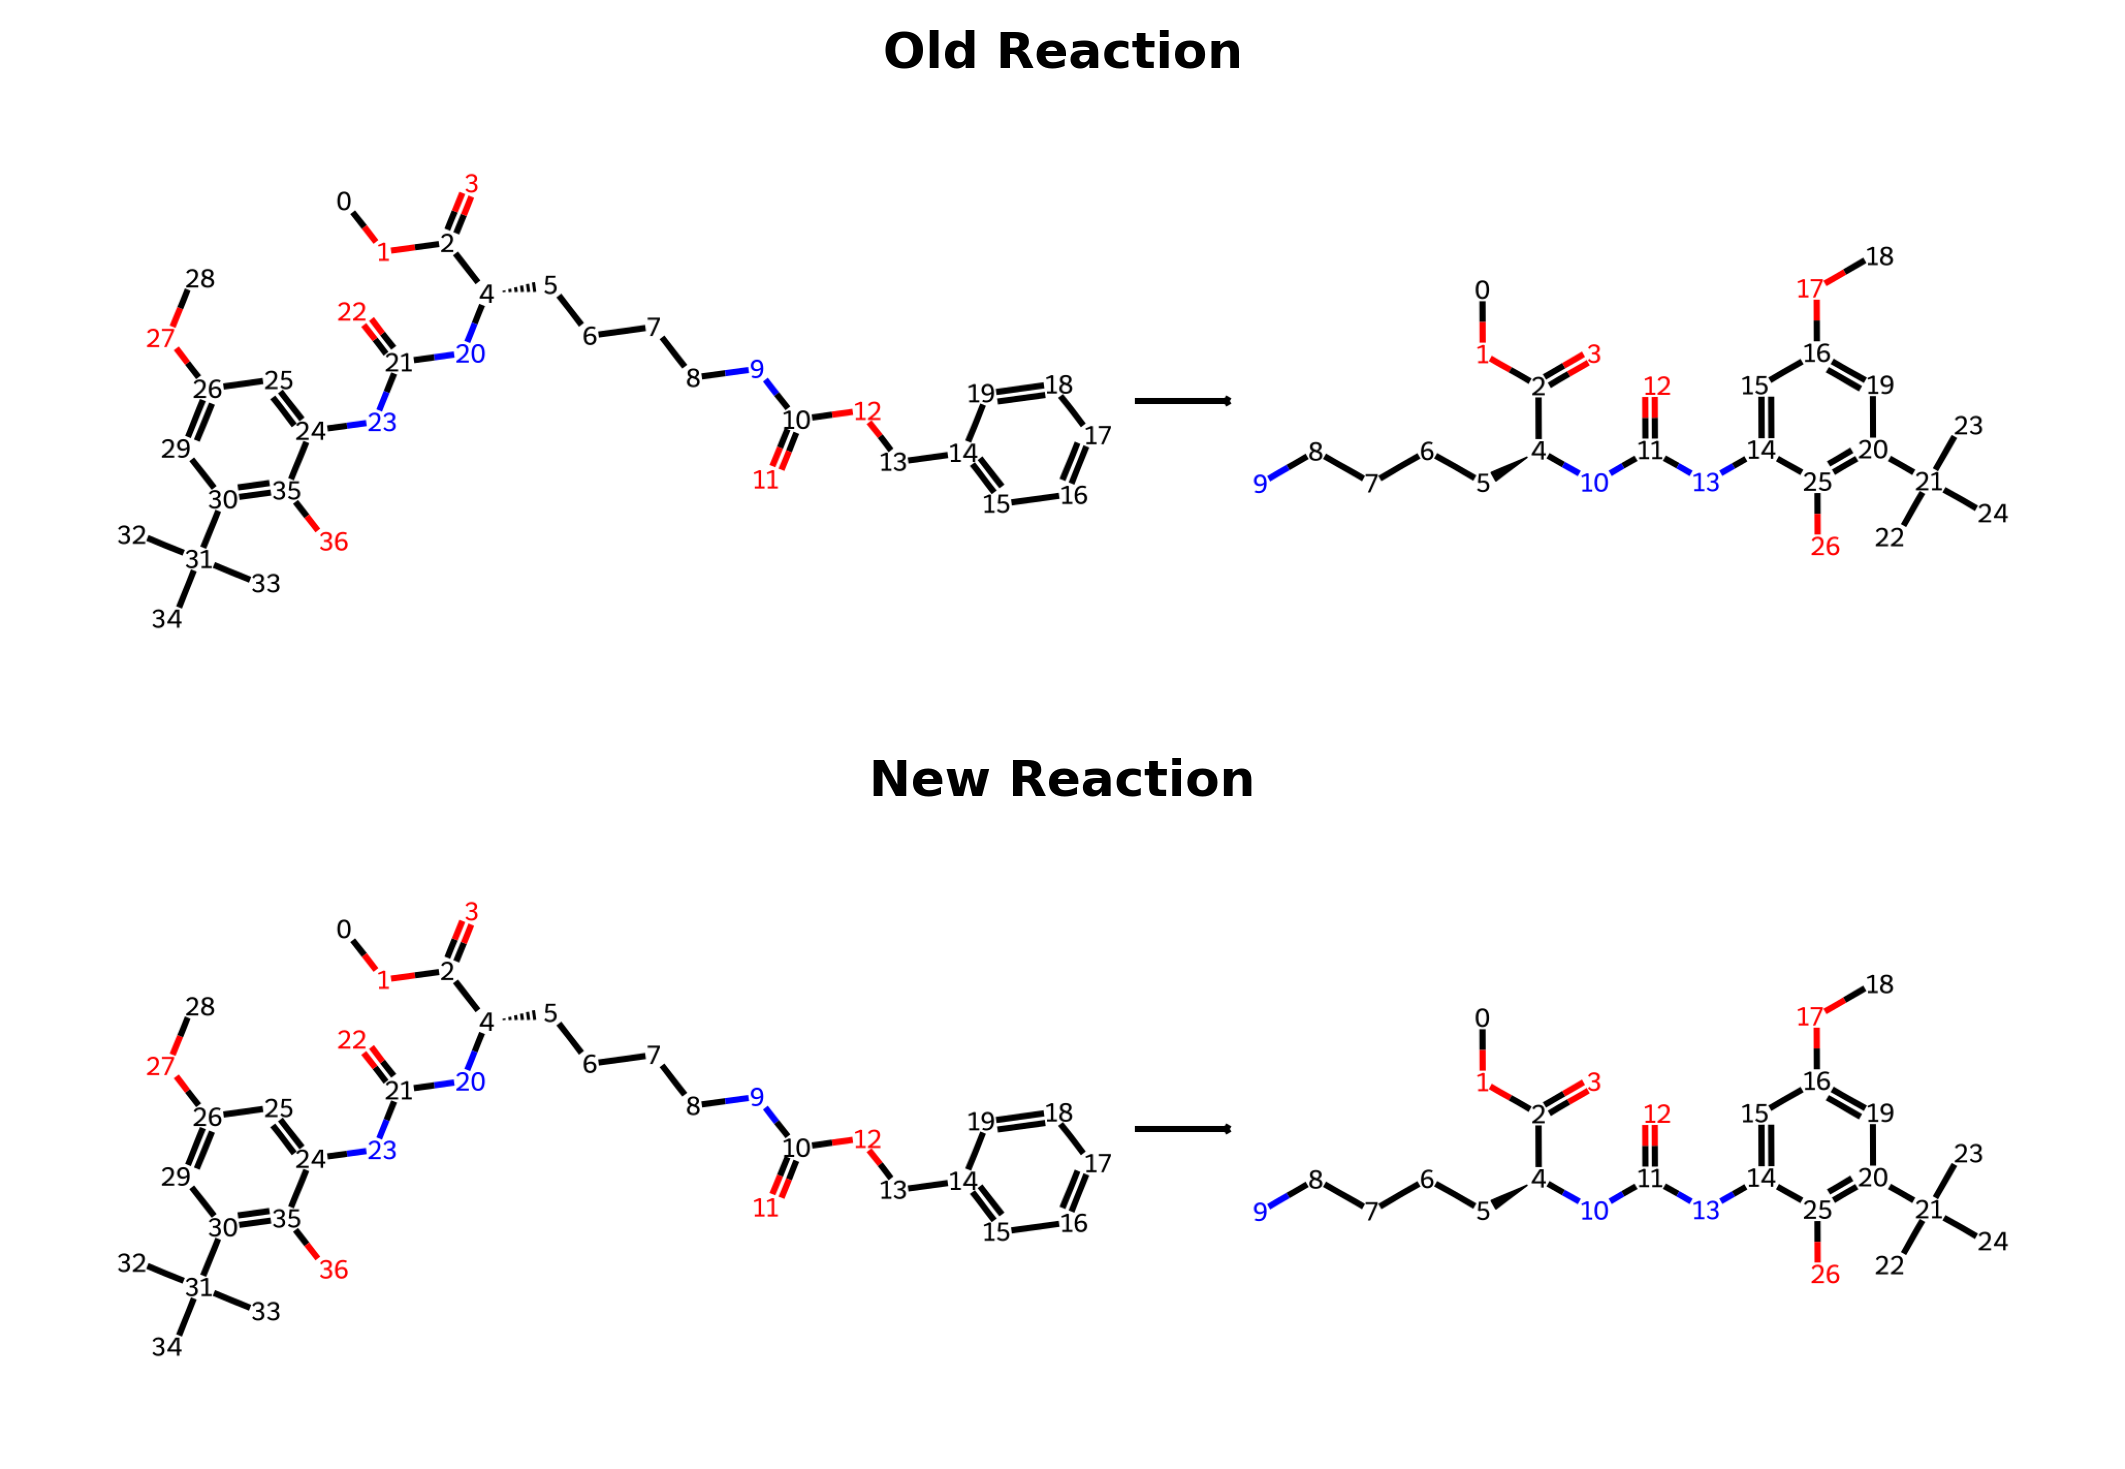

In [2]:
from SynRBL.SynVis.reaction_visualizer import ReactionVisualizer
vis = ReactionVisualizer()
vis.plot_reactions(original[0] , 'reactions', 'reactions', show_atom_numbers=True, compare= True, savefig=False, pathname = None, dpi=300)

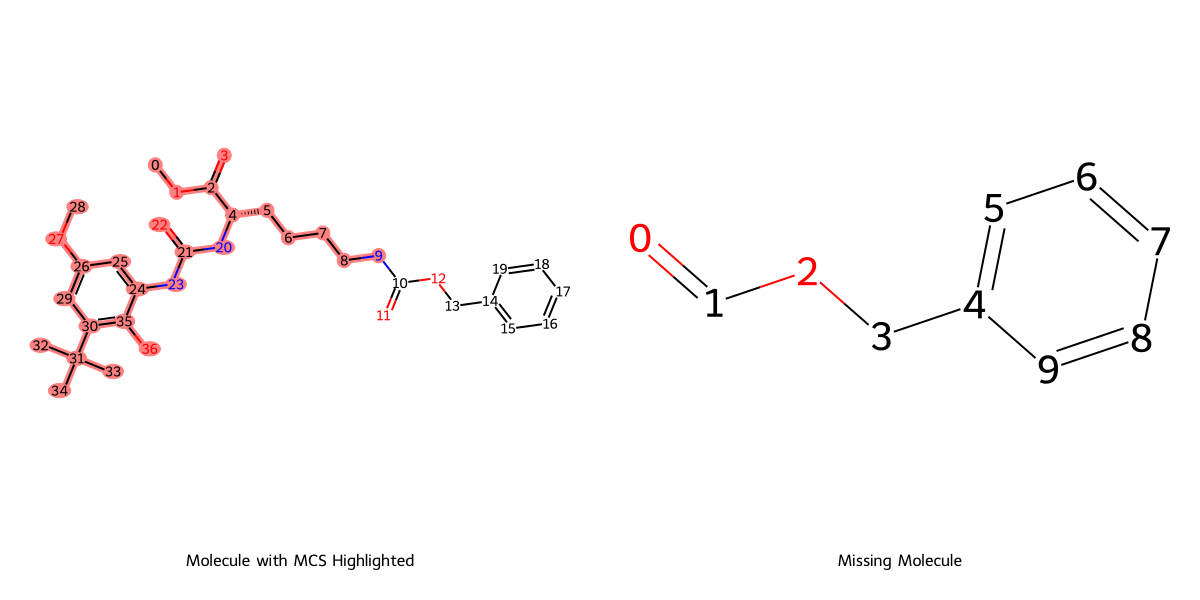

In [4]:
from SynRBL.SynVis.mcs_visualizer import  MCSVisualizer
mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(sorted_reactants[0][0], mcs_results[0][0], show_atom_numbers=True, compare=True, missing_graph_smiles=missing_results[0]['smiles'][0])
img

In [13]:
275
801

801

In [12]:
from rdkit import Chem

def is_metal(atom):
    """
    Check if an atom is a metal based on its atomic number.
    Metals are typically elements with an atomic number greater than 20 (Calcium).
    """
    # Atomic number greater than 20 indicates a metal in most common cases
    return atom.GetAtomicNum() > 20

def contains_metal(reaction_str):
    """
    Check if a chemical reaction contains metals.

    Parameters
    ----------
    reaction_str : str
        The SMILES representation of the reaction.

    Returns
    -------
    bool
        True if the reaction contains metals, False otherwise.
    """
    # Split the reaction into reactants and products
    reactants, products = reaction_str.split(">>")

    # Split individual molecules in reactants and products
    all_molecules = reactants.split('.') + products.split('.')

    for mol_str in all_molecules:
        mol = Chem.MolFromSmiles(mol_str)
        if mol is not None:
            for atom in mol.GetAtoms():
                if is_metal(atom):
                    return True

    return False

# Example usage
reaction = 'CC(=O)N[C@H](C(=O)N[C@H](C(=O)NC(Cc1ccccc1)C(O)C(Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)C(C)C)C(C)C)C(C)C)C(C)C>>CC(=O)N[C@H](C(=O)N[C@H](C(=O)NC(Cc1ccccc1)C(=O)C(Cc1ccccc1)NC(=O)[C@@H](NC(=O)[C@@H](NC(C)=O)C(C)C)C(C)C)C(C)C)C(C)C.[HH].[Na+]'
print(contains_metal(reaction))  # This will print True if the reaction contains metals, False otherwise.


False


[14:29:00] WARNING: not removing hydrogen atom without neighbors


[14:28:55] WARNING: not removing hydrogen atom without neighbors


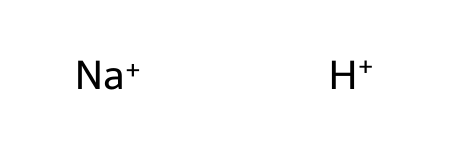

In [11]:
Chem.MolFromSmiles('[H+].[Na+]')

In [58]:
def draw_molecule_with_atom_numbers(mol):
    """
    Draw a molecule with atom numbers annotated.
    
    Parameters
    ----------
    mol : RDKit Molecule object
        The molecule to be drawn with atom numbers.
    
    Returns
    -------
    PIL.Image.Image
        An image of the molecule with atom numbers.
    """
    mol_with_atom_numbers = Chem.Mol(mol)
    for atom in mol_with_atom_numbers.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))
    return Draw.MolToImage(mol_with_atom_numbers, size=(300, 300))

In [4]:
def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(200, 200),
        **kwargs,
    )

In [79]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import rdFMCS as FMCS
from rdkit.Geometry import Point2D
from copy import deepcopy

def highlight_molecule(molecule, mcs, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in a single parent molecule.

    Parameters
    ----------
    molecule : RDKit Mol
        The parent molecule to be highlighted.
    mcs : RDKit Mol
        The MCS molecule.
    label : bool, optional
        If True, displays the label of the molecule. Default is True.
    same_orientation : bool, optional
        If True, aligns the MCS and the molecule in the same orientation. Default is True.
    kwargs : dict
        Additional keyword arguments for RDKit's MolsToGridImage.

    Returns
    -------
    PIL.Image.Image
        An image of the molecule with highlighted MCS.
    """
    #molecule = deepcopy(molecule)
    pattern = Chem.MolFromSmarts(Chem.CanonSmiles(mcs))

    # Find the matching atoms in the molecule
    matching = molecule.GetSubstructMatch(pattern)

    legend = molecule.GetProp("_Name") if label and molecule.HasProp("_Name") else None

    # Align by matched substructure for consistent depiction orientation
    if same_orientation and matching:
        AllChem.Compute2DCoords(molecule)
        coords = [molecule.GetConformer().GetAtomPosition(x) for x in matching]
        coords2D = [Point2D(pt.x, pt.y) for pt in coords]
        coord_dict = {match: coord for match, coord in zip(matching, coords2D)}
        AllChem.Compute2DCoords(molecule, coordMap=coord_dict)
    return Draw.MolToImage(molecule, size=(300, 300))

In [125]:
class MCSVisualizer:
    
    def __init__(self):
        pass

    @staticmethod
    def draw_molecule_with_atom_numbers(mol):
        """
        Draw a molecule with atom numbers annotated.
        
        Parameters
        ----------
        mol : RDKit Molecule object
            The molecule to be drawn with atom numbers.
        
        Returns
        -------
        PIL.Image.Image
            An image of the molecule with atom numbers.
        """
        mol_with_atom_numbers = Chem.Mol(mol)
        for atom in mol_with_atom_numbers.GetAtoms():
            atom.SetProp('atomLabel', str(atom.GetIdx()))
        return mol_with_atom_numbers

    def highlight_molecule(self, molecule_smiles, mcs_smiles, show_atom_numbers=False, compare=False, missing_graph_smiles=None):
        """
        Highlight the specified substructure (MCS) within a molecule and optionally compare with another molecule.

        Parameters
        ----------
        molecule_smiles : str
            SMILES representation of the molecule.
        mcs_smiles : str
            SMILES representation of the substructure (MCS).
        show_atom_numbers : bool, optional
            If True, shows atom numbers on the molecules.
        compare : bool, optional
            If True, shows a comparison with another molecule specified by missing_graph_smiles.
        missing_graph_smiles : str, optional
            SMILES representation of the second molecule for comparison.

        Returns
        -------
        PIL.Image.Image
            An image of the molecule with the specified substructure highlighted, and optionally the second molecule.
        """
        molecule = Chem.MolFromSmiles(molecule_smiles)
        pattern = Chem.MolFromSmarts(Chem.CanonSmiles(mcs_smiles))
        matching = molecule.GetSubstructMatch(pattern)

        if not matching:
            raise ValueError("Substructure not found in molecule.")

        if show_atom_numbers:
            molecule = self.draw_molecule_with_atom_numbers(molecule)

        mols = [molecule]
        highlight_lists = [matching] if matching else [None]
        legends = ['Molecule with MCS Highlighted']

        if compare and missing_graph_smiles:
            missing_graph = Chem.MolFromSmiles(missing_graph_smiles)
            if show_atom_numbers:
                missing_graph = self.draw_molecule_with_atom_numbers(missing_graph)
            mols.append(missing_graph)
            highlight_lists.append(None)  # No highlighting for the comparison molecule
            legends.append('Disconnected Molecule')
            molsPerRow = 2
        else:
            molsPerRow = 1

        return Draw.MolsToGridImage(mols, molsPerRow=molsPerRow, highlightAtomLists=highlight_lists, legends=legends, subImgSize=(600, 600))



In [168]:
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
import io
from PIL import Image

class MCSVisualizer:
    """
    A class for visualizing molecules and highlighting their Maximum Common Substructure (MCS).

    Methods
    -------
    draw_molecule_with_atom_numbers(mol):
        Annotates a molecule with atom indices.

    highlight_molecule(molecule_smiles, mcs_smiles, show_atom_numbers=False, compare=False, missing_graph_smiles=None):
        Highlights the specified substructure within a molecule and optionally compares it with another molecule.
    """
    
    def __init__(self):
        pass

    def draw_molecule_with_atom_numbers(self, mol):
        """
        Annotates a molecule with atom indices.
        
        Parameters
        ----------
        mol : RDKit Molecule object
            The molecule to be annotated with atom numbers.
        
        Returns
        -------
        RDKit Mol object
            The annotated molecule.
        """
        mol_with_atom_numbers = Chem.Mol(mol)
        for atom in mol_with_atom_numbers.GetAtoms():
            atom.SetProp('atomLabel', str(atom.GetIdx()))
        return mol_with_atom_numbers

    def highlight_molecule(self, molecule_smiles, mcs_smiles, show_atom_numbers=False, compare=False, missing_graph_smiles=None):
        """
        Highlights the specified substructure (MCS) within a molecule and optionally compares it with another molecule.
        
        Parameters
        ----------
        molecule_smiles : str
            SMILES representation of the molecule.
        mcs_smiles : str
            SMILES representation of the substructure (MCS).
        show_atom_numbers : bool, optional
            If True, shows atom numbers on the molecules.
        compare : bool, optional
            If True, shows a comparison with another molecule specified by missing_graph_smiles.
        missing_graph_smiles : str, optional
            SMILES representation of the second molecule for comparison.

        Returns
        -------
        PIL.Image.Image
            An image of the molecule with the specified substructure highlighted, and optionally the second molecule.
        
        Example
        -------
        visualizer = MCSVisualizer()
        img = visualizer.highlight_molecule('CCO', 'CO', compare=True, missing_graph_smiles='CCC')
        img.show()
        """
        molecule = Chem.MolFromSmiles(molecule_smiles)
        pattern = Chem.MolFromSmarts(Chem.CanonSmiles(mcs_smiles))
        matching = molecule.GetSubstructMatch(pattern)

        if not matching:
            raise ValueError("Substructure not found in molecule.")

        if show_atom_numbers:
            molecule = self.draw_molecule_with_atom_numbers(molecule)

        mols = [molecule]
        highlight_lists = [matching] if matching else [None]
        legends = ['Molecule with MCS Highlighted']

        # Check if a comparison molecule is needed
        if compare and missing_graph_smiles:
            missing_graph = Chem.MolFromSmiles(missing_graph_smiles)
            if show_atom_numbers:
                missing_graph = self.draw_molecule_with_atom_numbers(missing_graph)
            mols.append(missing_graph)
            highlight_lists.append(None)
            legends.append('Comparison Molecule')

        # Image dimensions
        width, height = 600, 600
        molsPerRow = 2 if compare else 1
        img_width = width * molsPerRow
        img_height = height * len(mols) // molsPerRow

        # Create a drawing object
        drawer = rdMolDraw2D.MolDraw2DCairo(img_width, img_height, width, height)

        # Draw each molecule
        for i, mol in enumerate(mols):
            row = i // molsPerRow
            col = i % molsPerRow
            x_offset = width * col
            y_offset = height * row
            drawer.SetOffset(x_offset, y_offset)
            drawer.DrawMolecule(mol, legend=legends[i], highlightAtoms=highlight_lists[i])
        
        drawer.FinishDrawing()

        return Image.open(io.BytesIO(drawer.GetDrawingText()))


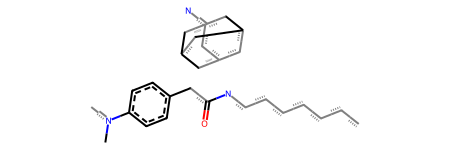

In [169]:
from rdkit.Chem import rdRascalMCES
mol1 = Chem.MolFromSmiles("CN(C)c1ccc(CC(=O)NCCCCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1 CHEMBL153934")
mol2 = Chem.MolFromSmiles("CN(C)c1ccc(CC(=O)NCCCCCCCNC23CC4CC(C2)CC(C3)C4)cc1 CHEMBL152361")
res = rdRascalMCES.FindMCES(mol1, mol2)
Chem.MolFromSmarts(res[0].smartsString)


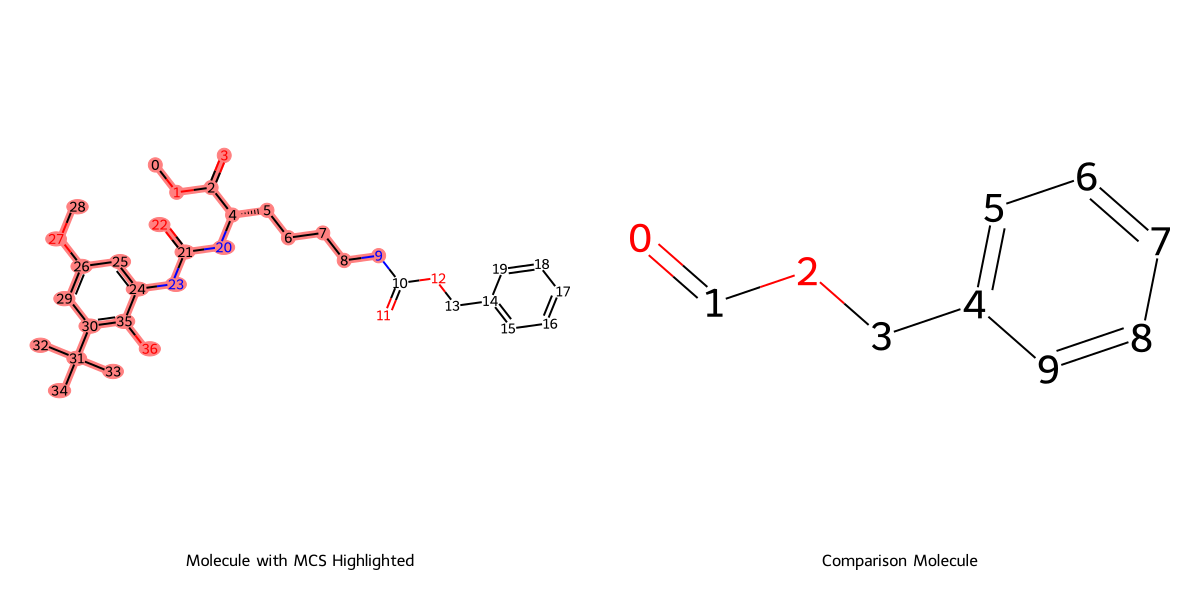

In [172]:
mcs_vis = MCSVisualizer()
img= mcs_vis.highlight_molecule(sorted_reactants[0][0], mcs_results[0][0], show_atom_numbers=True, compare=True, missing_graph_smiles=missing_results[0]['smiles'][0])
img

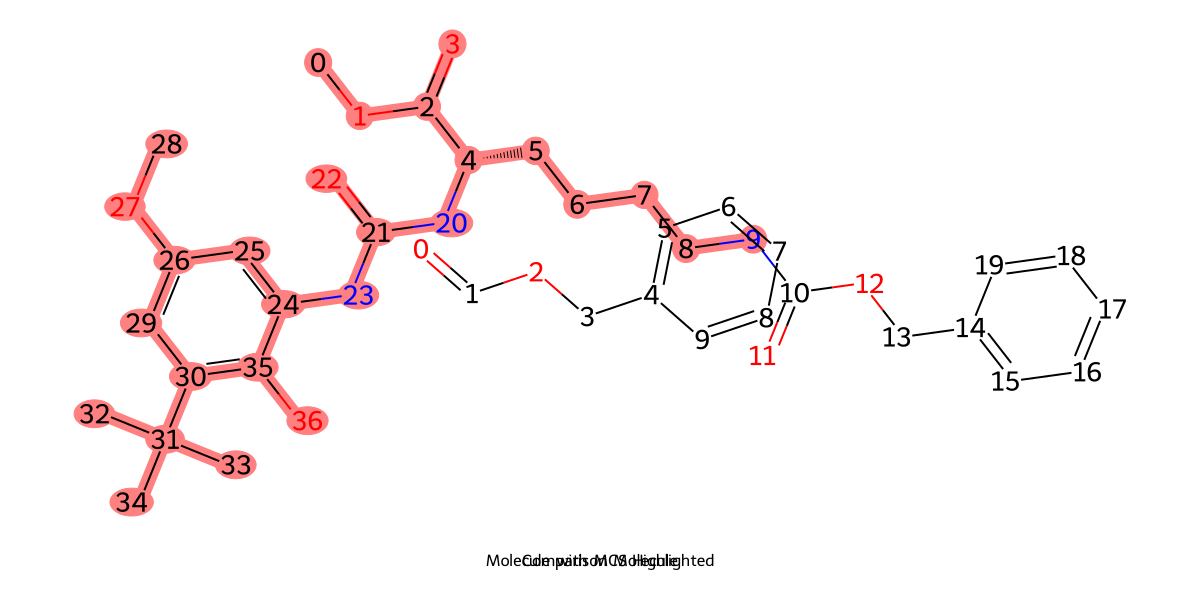

In [135]:
img

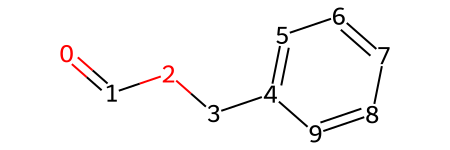

In [113]:
mcs_vis.draw_molecule_with_atom_numbers(Chem.MolFromSmiles(missing_results[0]['smiles'][0]))

In [114]:
missing_results[0]

{'smiles': ['O=COCc1ccccc1'],
 'boundary_atoms_products': [[{'C': 1}]],
 'nearest_neighbor_products': [[{'N': 9}]],
 'issue': ''}

In [109]:
missing_results[0]['smiles'][0]

'O=COCc1ccccc1'

In [ ]:
missing_results[0]['smiles'][0]

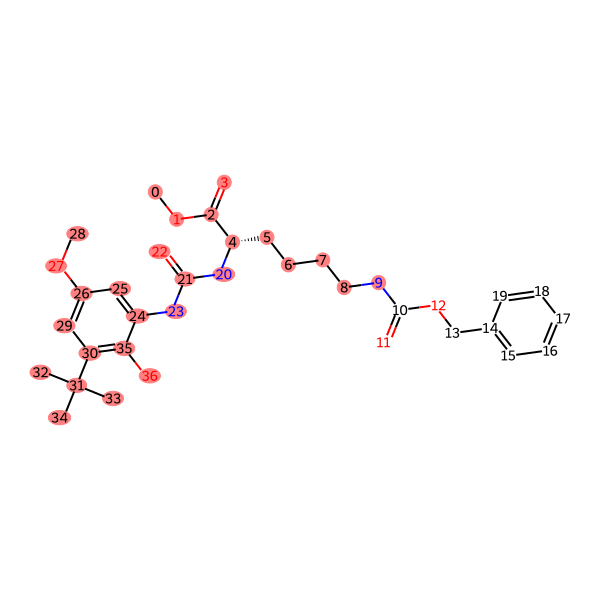

In [98]:
mcs_vis = MCSVisualizer()
mcs_vis.highlight_molecule(sorted_reactants[0][0], mcs_results[0][0], show_atom_numbers=True)

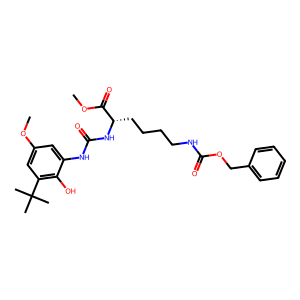

In [80]:
highlight_molecule(molecule, mcs_results[0][0], label=True, same_orientation=True)

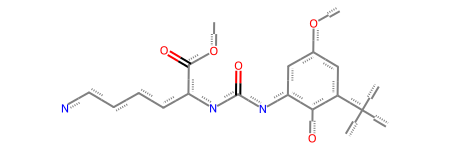

In [81]:
pattern = Chem.MolFromSmarts(Chem.CanonSmiles(mcs_results[0][0]))
pattern

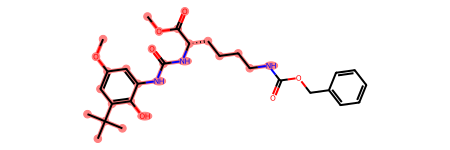

In [82]:
molecule = sorted_reactants_mol_list[0][0]
Chem.SanitizeMol(molecule)
molecule

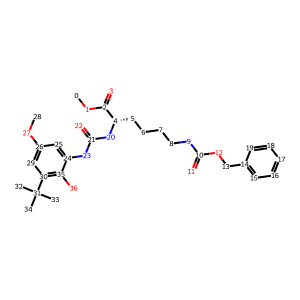

In [73]:
draw_molecule_with_atom_numbers(molecule)

In [64]:
matching = molecule.GetSubstructMatch(pattern)
matching

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36)

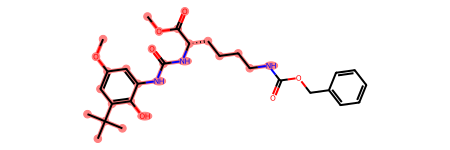

In [65]:
molecule

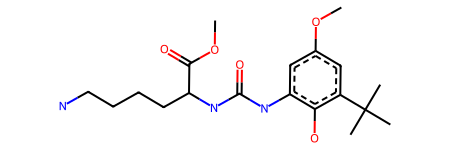

In [74]:
from rdkit.Chem import rdFMCS

mcs = rdFMCS.FindMCS([molecule, pattern])
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
mcs_mol

In [75]:
molecule.GetSubstructMatch(mcs_mol)

(0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 35,
 36,
 31,
 32,
 33,
 34)

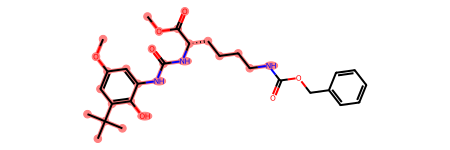

In [76]:
molecule

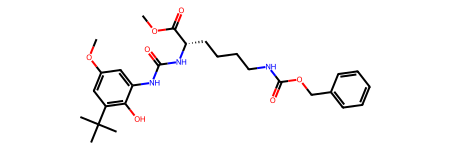

In [32]:
molecule.GetSubstructMatch(pattern)

()

In [29]:
sorted_reactants_mol_list[0][0].HasSubstructMatch()

False

In [26]:
matching = sorted_reactants_mol_list[0][0].GetSubstructMatch(pattern)

In [100]:
find_graph = FindMissingGraphs()
missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=10, use_findMCS=True)
missing_final = pd.DataFrame(missing_results)

missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:]
print('Bug:', len(non_pass_df))

Bug: 0


In [105]:
missing_results[0]['smiles'][0]

'O=COCc1ccccc1'

In [9]:
from SynRBL.SynMCS import FindMissingGraphs
#from SynRBL.rsmi_utils import draw_molecule_with_atom_numbers
mol_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['sorted_reactants']]
mcs_list = [Chem.MolFromSmiles(i) for i in mcs_results_dict['mcs_results']]

find_graph = FindMissingGraphs()
missing_graph, boundary, neighbor = find_graph.find_missing_parts_pairs(mol_list=mol_list, mcs_list=mcs_list,use_findMCS=True)



print('Reactants')
print('Neighbor Atom:', neighbor)
display(draw_molecule_with_atom_numbers(mol_list[0]))

print('Missing compounds in Products')
print('Boundary Atom:', boundary)
display(draw_molecule_with_atom_numbers(missing_graph[0]))



NameError: name 'mcs_results_dict' is not defined

In [ ]:
from rdkit.Chem import  Draw
def draw_molecule_with_atom_numbers(mol):
    """
    Draw a molecule with atom numbers annotated.
    
    :param mol: RDKit Molecule object.
    :return: An image of the molecule with atom numbers.
    """
    # Create a copy of the molecule
    mol_with_atom_numbers = Chem.Mol(mol)
    
    # Add atom numbers
    for atom in mol_with_atom_numbers.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    # Draw the molecule
    return Draw.MolToImage(mol_with_atom_numbers, size=(300, 300))

draw_molecule_with_atom_numbers(Chem.MolFromSmiles(original[0]['products']))

In [6]:
def check_for_bug(dataframe):
    ind_key = []
    for key, value in enumerate(dataframe['boundary_atoms_products']):
        if len(value) == 0:
            ind_key.append(key)

    bug_rows = dataframe.iloc[ind_key, :]
    return bug_rows
bug_data = check_for_bug(missing_final)
print('Bug:', len(bug_data))

Bug: 2


In [7]:
missing_final.drop(bug_data.index,axis=0)

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[O=COCc1ccccc1],[[{'C': 1}]],[[{'N': 9}]],NaN
1,"[CC1(C)OBOC1(C)C, Br]","[[{'B': 4}], [{'Br': 0}]]","[[{'C': 5}], [{'C': 13}]]",NaN
2,[CC(C)C],[[{'C': 1}]],[[{'O': 4}]],NaN
3,[COc1ccc(C)cc1],[[{'C': 6}]],[[{'N': 8}]],NaN
4,[C],[[{'C': 0}]],[[{'O': 1}]],NaN
...,...,...,...,...
17454,[O],[[{'O': 0}]],[[{'C': 8}]],NaN
17455,[O],[[{'O': 0}]],[[{'C': 3}]],NaN
17456,[O],[[{'O': 0}]],[[{'C': 1}]],NaN
17457,[O],[[{'O': 0}]],[[{'C': 9}]],NaN


In [102]:
bug_data.describe()

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
count,159,159,159,43
unique,1,1,1,1
top,[],[],[],Python argument types in\n RWMol.__init__(R...
freq,159,159,159,43


In [93]:
check_for_bug(missing_final).shape

(159, 4)

In [80]:
non_pass_df['issue']

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
7,[],[],[],Python argument types in\n RWMol.__init__(R...
38,[],[],[],Python argument types in\n RWMol.__init__(R...
72,[],[],[],Python argument types in\n RWMol.__init__(R...
82,[],[],[],Python argument types in\n RWMol.__init__(R...
84,[],[],[],Python argument types in\n RWMol.__init__(R...
85,[],[],[],Python argument types in\n RWMol.__init__(R...
96,[],[],[],Python argument types in\n RWMol.__init__(R...
111,[],[],[],Python argument types in\n RWMol.__init__(R...
136,[],[],[],Python argument types in\n RWMol.__init__(R...
144,[],[],[],Python argument types in\n RWMol.__init__(R...


In [21]:
missing_results

[{'smiles': ['O=COCc1ccccc1'],
  'boundary_atoms_products': [[{'C': 1}]],
  'nearest_neighbor_products': [[{'N': 9}]],
  'issue': ''},
 {'smiles': ['CC1(C)OBOC1(C)C', 'Br'],
  'boundary_atoms_products': [[{'B': 4}], [{'Br': 0}]],
  'nearest_neighbor_products': [[{'C': 5}], [{'C': 13}]],
  'issue': ''},
 {'smiles': ['CC(C)C'],
  'boundary_atoms_products': [[{'C': 1}]],
  'nearest_neighbor_products': [[{'O': 4}]],
  'issue': ''},
 {'smiles': ['COc1ccc(C)cc1'],
  'boundary_atoms_products': [[{'C': 6}]],
  'nearest_neighbor_products': [[{'N': 8}]],
  'issue': ''},
 {'smiles': ['C'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'O': 1}]],
  'issue': ''},
 {'smiles': ['Cc1ccccc1'],
  'boundary_atoms_products': [[{'C': 0}]],
  'nearest_neighbor_products': [[{'N': 17}]],
  'issue': ''},
 {'smiles': ['C[SiH](C)C'],
  'boundary_atoms_products': [[{'Si': 1}]],
  'nearest_neighbor_products': [[{'C': 4}]],
  'issue': ''},
 {'smiles': ['C'],
  'boundary_atoms_products

In [12]:
def is_mapping_correct(mol, symbol_to_index):
    # Convert the molecule to a dictionary of atom indices to symbols
    molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
    
    # Check if the mappings are consistent
    for symbol, index in symbol_to_index.items():
        if index not in molecule_dict:
            return False
        if molecule_dict[index] != symbol:
            return False
    
    return True
#is_mapping_correct(mol=Chem.MolFromSmiles('O=COCc1ccccc1'), symbol_to_index={'C': 1})
all_conditions_met = all(is_mapping_correct(Chem.MolFromSmiles(smiles_list[key]), boundary_atoms_products[key][0]) for key in range(len(smiles_list)))


In [19]:
missing_results

[{'smiles': ['O=COCc1ccccc1'],
  'boundary_atoms_products': [[{'C': 1}]],
  'nearest_neighbor_products': [[{'N': 9}]],
  'issue': ''},
 {'smiles': ['CC1(C)OBOC1(C)C', 'Br'],
  'boundary_atoms_products': [[{'B': 4}], [{'Br': 0}]],
  'nearest_neighbor_products': [[{'C': 5}], [{'C': 13}]],
  'issue': ''},
 {'smiles': ['CC(C)C'],
  'boundary_atoms_products': [[{'C': 1}]],
  'nearest_neighbor_products': [[{'O': 4}]],
  'issue': ''},
 {'smiles': ['COc1ccc(C)cc1'],
  'boundary_atoms_products': [[{'C': 6}]],
  'nearest_neighbor_products': [[{'N': 8}]],
  'issue': ''}]

In [24]:
fail = []
check = []
for check_dict in missing_results:
    smiles_list = check_dict['smiles']
    boundary_list = check_dict['boundary_atoms_products']

    all_conditions_met = all(is_mapping_correct(Chem.MolFromSmiles(smiles_list[key]), boundary_list[key][0]) for key in range(len(smiles_list)))
    print(all_conditions_met)
    if all_conditions_met:
        check.append(smiles_list)
    else:
        fail.append(smiles_list)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [56]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed
from rdkit.Chem import rdmolops
import copy

def add_hydrogens_to_radicals(mol: Chem.Mol) -> Chem.Mol:
    """
    Add hydrogen atoms to radical sites in a molecule.

    Args:
    - mol (Chem.Mol): RDKit molecule object.

    Returns:
    - Chem.Mol: The modified molecule with added hydrogens.
    """
    # Create a copy of the molecule
    mol_with_h = Chem.RWMol(mol)

    # Add explicit hydrogens (not necessary if they are already present in the input molecule)
    mol_with_h = rdmolops.AddHs(mol_with_h)

    # Find and process radical atoms
    for atom in mol_with_h.GetAtoms():
        num_radical_electrons = atom.GetNumRadicalElectrons()
        if num_radical_electrons > 0:
            atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
            atom.SetNumRadicalElectrons(0)
    
    curate_mol = Chem.RemoveHs(mol_with_h)
    return curate_mol

def map_parent_to_child(parent_mol, child_mol, key_base):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        map_key = key_base[parent_idx]
        atom_mapping[map_key] = child_idx

    return atom_mapping

In [15]:
smiles_list

['COc1ccc(C)cc1']

In [14]:
len(check)

4

In [6]:
def check_bug(missing_results):
    missing_final = pd.DataFrame(missing_results)
    missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
    non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
    print('Bug in Issues:', len(non_pass_df))

    ind_key = []
    for key, value in enumerate(missing_final['boundary_atoms_products']):
        if len(value)==0:
            ind_key.append(key)

    
    print('No Boundary atoms:', len(missing_final.iloc[ind_key,:]))



In [8]:
check_bug(missing_results)

Bug in Issues: 0
No Boundary atoms: 2


In [82]:
ind_key = []
for key, value in enumerate(missing_final['boundary_atoms_products']):
    if len(value)==0:
        ind_key.append(key)

bug_check = missing_final.iloc[ind_key,:]

In [83]:
bug_check

,smiles,boundary_atoms_products,nearest_neighbor_products,issue
7,[],[],[],Python argument types in\n RWMol.__init__(R...
38,[],[],[],Python argument types in\n RWMol.__init__(R...
72,[],[],[],Python argument types in\n RWMol.__init__(R...
82,[],[],[],Python argument types in\n RWMol.__init__(R...
84,[],[],[],Python argument types in\n RWMol.__init__(R...
...,...,...,...,...
1209,[],[],[],NaN
1211,[],[],[],NaN
1214,[],[],[],NaN
1215,[],[],[],NaN


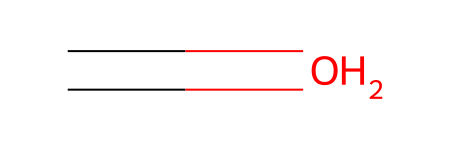

In [87]:
sorted_reactants_mol_list[1216][1]

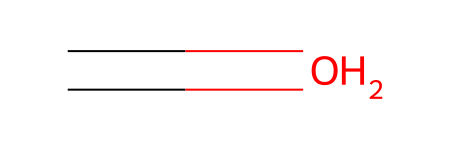

In [88]:
mcs_mol_list[1216][1]

In [63]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed
from rdkit.Chem import rdmolops
mcs = rdFMCS.FindMCS([sorted_reactants_mol_list[2305][0], mcs_mol_list[2305][0]])
mcs_mol = Chem.MolFromSmarts(mcs.smartsString)

In [70]:
sorted_reactants_mol_list[2305]

In [71]:
mcs_mol_list[2305]

In [72]:
find = FindMissingGraphs()
find.find_missing_parts_pairs(sorted_reactants_mol_list[2305], mcs_mol_list[2305], use_findMCS=True)

([], [], [])

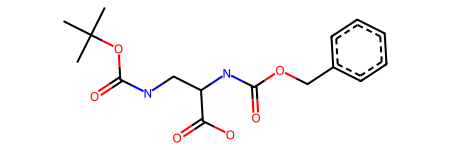

In [60]:
mcs_mol

In [44]:
atoms_to_remove = set()
substructure_match = sorted_reactants_mol_list[2350][0].GetSubstructMatch(mcs_mol)
if substructure_match:
    atoms_to_remove.update(substructure_match)


left_number = []
for i in range(sorted_reactants_mol_list[2350][0].GetNumAtoms()):
    if i not in substructure_match:
        left_number.append(i)


In [57]:
import copy
missing_part = Chem.RWMol(sorted_reactants_mol_list[2350][0])
for idx in sorted(atoms_to_remove, reverse=True):
    missing_part.RemoveAtom(idx)

missing_part_old = copy.deepcopy(missing_part)
missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))

missing_part = add_hydrogens_to_radicals(missing_part)
atom_mapping = map_parent_to_child(missing_part_old, missing_part, left_number)

In [58]:
atom_mapping

{0: 0}

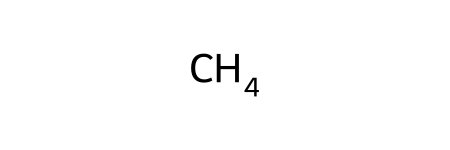

In [52]:
missing_part

In [ ]:
substructure_match = mol.GetSubstructMatch(mcs_mol)
if substructure_match:
atoms_to_remove.update(substructure_match)


left_number = []
for i in range(mol.GetNumAtoms()):
if i not in substructure_match:
    left_number.append(i)


# Creating the molecule of missing parts
missing_part = Chem.RWMol(mol)
for idx in sorted(atoms_to_remove, reverse=True):
missing_part.RemoveAtom(idx)

In [ ]:
def is_mapping_correct(mol, symbol_to_index):
    # Convert the molecule to a dictionary of atom indices to symbols
    molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
    
    # Check if the mappings are consistent
    for symbol, index in symbol_to_index.items():
        if index not in molecule_dict:
            return False
        if molecule_dict[index] != symbol:
            return False
    
    return True
is_mapping_correct(mol=Chem.MolFromSmiles('O=COCc1ccccc1'), symbol_to_index={'C': 1})